<a href="https://colab.research.google.com/github/e-vdb/toxic-comment-classification/blob/main/toxicCommentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emelinevanderbeken","key":"fdef7825bb20ad21c25fc469ea16f6fd"}'}

In [3]:
 ! mkdir ~/.kaggle 
 ! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 49.0MB/s]
 77% 18.0M/23.4M [00:00<00:00, 59.2MB/s]
100% 23.4M/23.4M [00:00<00:00, 66.1MB/s]
 34% 9.00M/26.3M [00:00<00:00, 65.4MB/s]
100% 26.3M/26.3M [00:00<00:00, 104MB/s] 
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 97.8MB/s]


In [6]:
! mkdir data
! unzip train.csv.zip -d data

Archive:  train.csv.zip
  inflating: data/train.csv          


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
import warnings
import spacy
en_nlp = spacy.load('en')

In [8]:
filepath='data/train.csv'
data_train=pd.read_csv(filepath)
df_train=data_train.copy()

# 1. Exploratory data analysis

In [9]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
print(df_train.shape)
print("Train dataset columns = {}".format(df_train.columns))

(159571, 8)
Train dataset columns = Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [11]:
categories=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
train_labels=df_train[categories]
labels_count=train_labels.sum()
print(labels_count)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


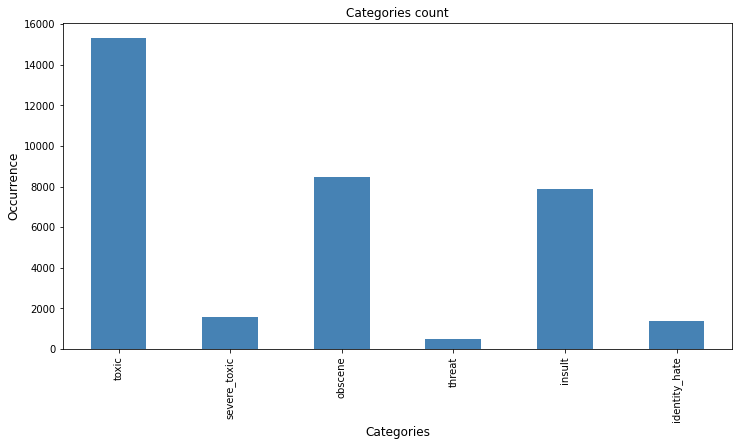

In [12]:
plt.figure(figsize=(12,6))
labels_count.plot(kind='bar', title='Labels Frequency', color='steelblue')
plt.title('Categories count')
plt.ylabel('Occurrence', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.show()

Toxicity label representation
 Categories number- Occurence-Percentage of dataset
0	 143346	 89.83 
1	 6360	 3.99 
3	 4209	 2.64 
2	 3480	 2.18 
4	 1760	 1.10 
5	 385	 0.24 
6	 31	 0.02 


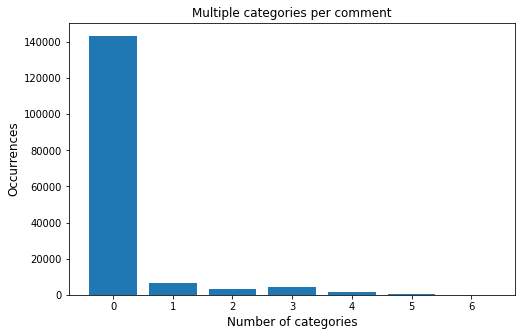

In [13]:
rowsums = df_train.iloc[:,2:].sum(axis=1)
categ_representation=rowsums.value_counts()
print("Toxicity label representation\n Categories number- Occurence-Percentage of dataset")
for nb,occ in zip(categ_representation.index,categ_representation.values):
  print("{}\t {}\t {:.2f} ".format(nb,occ,occ/len(df_train)*100))
plt.figure(figsize=(8,5))
plt.bar(categ_representation.index, categ_representation.values)
plt.title("Multiple categories per comment")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Number of categories', fontsize=12)
plt.show()

# 2. Data preprocessing

In [14]:
X=df_train['comment_text']
print('First comment:\n {}'.format(X[0]))


First comment:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [15]:
def clean_text(text):
  text=text.lower()
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"\'ll", " will ", text)
  text=re.sub('\W',' ',text)
  text=text.strip(' ')
  return text

In [16]:
X_clean=X.map(lambda com:clean_text(com))
print('First comment (cleaned):\n {}'.format(X_clean[0]))

First comment (cleaned):
 explanation why the edits made under my username hardcore metallica fan were reverted  they were not  vandalisms  just closure on some gas after i voted at new york dolls fac  and please do not  remove the template from the talk page since i m retired now 89 205 38 27


In [17]:
y=df_train[categories]
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


# 3. Machine learning

In [18]:
y.iloc[:,0]

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Name: toxic, Length: 159571, dtype: int64

In [19]:
def training_model(model):
    X_train,X_test,y_train,y_test=train_test_split(X_clean,y,random_state=0)
    model.fit(X_train,y_train)
    y_train_pred=predictions=model.predict(X_train)
    print("f1 score (train dataset) = {}".format(f1_score(y_train, y_train_pred, average='weighted')))
    y_test_pred=model.predict(X_test)
    print("f1 score (test dataset) = {}".format(f1_score(y_test, y_test_pred, average='weighted')))
    f1_score_cat=[f1_score(y_test.iloc[:,count],y_test_pred[:,count], average='weighted') for count in range(len(categories))]
    dic={category:f1Score for category,f1Score in zip(categories,f1_score_cat)}
    return pd.Series(data=dic,index=categories,name='f1_score')

def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# Mute warnings
warnings.filterwarnings('ignore')

# Multinomial Naive Bayes

## Standard count vectorizer

In [ ]:
clfNB=Pipeline([('cvec',CountVectorizer()),('nb',MultiOutputClassifier(MultinomialNB()))])
f1_score_clfNB=training_model(clfNB)
f1_score_clfNB

f1 score (train dataset) = 0.6635981911630696
f1 score (test dataset) = 0.623434065306382


toxic            0.943936
severe_toxic     0.987939
obscene          0.965947
threat           0.995720
insult           0.962221
identity_hate    0.987008
Name: f1_score, dtype: float64

## Tfidf vectorizer

In [ ]:
clf_tfidf_NB=Pipeline([('tfidf', TfidfVectorizer()),('nb',MultiOutputClassifier(MultinomialNB()))])
f1_score_clf_tfidf_NB=training_model(clf_tfidf_NB)
f1_score_clf_tfidf_NB

f1 score (train dataset) = 0.2039710113525343
f1 score (test dataset) = 0.16487202207306348


toxic            0.889007
severe_toxic     0.984410
obscene          0.931439
threat           0.995928
insult           0.930564
identity_hate    0.986434
Name: f1_score, dtype: float64

# Linear Support Vector Machine classifier

## Standard count vectorizer

In [ ]:
clfSVC=Pipeline([('cvec',CountVectorizer()),('svc',MultiOutputClassifier(LinearSVC()))])
f1_score_clfSVC=training_model(clfSVC)
f1_score_clfSVC

f1 score (train dataset) = 0.9695578873781824
f1 score (test dataset) = 0.6764681257601953


toxic            0.953915
severe_toxic     0.987288
obscene          0.975657
threat           0.996335
insult           0.960833
identity_hate    0.988094
Name: f1_score, dtype: float64

## Tfidf vectorizer

In [ ]:
clf_tfidf_SVC=Pipeline([('tfidf', TfidfVectorizer()),('svc',MultiOutputClassifier(LinearSVC()))])
f1_score_clf_tfidf_SVC=training_model(clf_tfidf_SVC)
f1_score_clf_tfidf_SVC

f1 score (train dataset) = 0.9182322821572066
f1 score (test dataset) = 0.7096072144387268


toxic            0.958378
severe_toxic     0.988461
obscene          0.978227
threat           0.997079
insult           0.968850
identity_hate    0.990418
Name: f1_score, dtype: float64

# Logistic Regression

## Standard count vectorizer

In [ ]:
cvLG=Pipeline([('cvec',CountVectorizer(min_df=5)),('lg',MultiOutputClassifier(LogisticRegression(solver='liblinear', max_iter=500)))])
f1_score_cvLG=training_model(cvLG)
f1_score_cvLG

f1 score (train dataset) = 0.6229390512632211
f1 score (test dataset) = 0.5883674132245024


toxic            0.948077
severe_toxic     0.987710
obscene          0.967362
threat           0.996351
insult           0.954862
identity_hate    0.987434
Name: f1_score, dtype: float64

## Tfidf vectorizer

In [ ]:
cv_tfidf_LG=Pipeline([('tfidf', TfidfVectorizer()),('lg',MultiOutputClassifier(LogisticRegression(solver='sag', max_iter=500)))])
f1_score_cv_tfidf_LG=training_model(cv_tfidf_LG)
f1_score_cv_tfidf_LG

f1 score (train dataset) = 0.6942108800087852
f1 score (test dataset) = 0.6595716164251947


toxic            0.950270
severe_toxic     0.988213
obscene          0.974531
threat           0.996738
insult           0.967257
identity_hate    0.989218
Name: f1_score, dtype: float64

# Parameters tuning with GridSearch CV

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X_clean,y,random_state=0)

## Logistic Regression

In [ ]:
cvLG=Pipeline([('cvec',CountVectorizer(min_df=5)),('lg',MultiOutputClassifier(LogisticRegression(solver='liblinear', max_iter=500)))])

In [ ]:
grid_params= {
 'cvec__ngram_range': [(1, 1)],
 'lg__estimator__C':[1,10],
}
model_gs=GridSearchCV(cvLG,param_grid=grid_params,cv=5,scoring='f1_weighted',verbose=5,n_jobs=-1)

model_gs.fit(X_train,y_train)
print("Best parameters {}".format(model_gs.best_params_))
print("Best score: {:.3f}".format(model_gs.best_score_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 34.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 34.8min finished


Best parameters {'cvec__ngram_range': (1, 1), 'lg__estimator__C': 10}
Best score: 0.617


In [ ]:
y_test_pred=model_gs.predict(X_test)
print("f1 score (test dataset) = {}".format(f1_score(y_test, y_test_pred, average='weighted')))

f1 score (test dataset) = 0.5886321339707757


## Linear Support Vector Machine classifier

In [22]:
grid_params= {
 'cvec__ngram_range': [(1, 1)],
 'svc__estimator__C':[1,10],
}
clfSVC=Pipeline([('cvec',CountVectorizer()),('svc',MultiOutputClassifier(LinearSVC()))])
grid_clfSVC=GridSearchCV(clfSVC,param_grid=grid_params,cv=5,scoring='f1_weighted',verbose=5,n_jobs=-1)
grid_clfSVC.fit(X_train,y_train)
print("Best parameters {}".format(grid_clfSVC.best_params_))
print("Best score: {:.3f}".format(grid_clfSVC.best_score_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.7min finished


Best parameters {'cvec__ngram_range': (1, 1), 'svc__estimator__C': 1}
Best score: 0.680


In [23]:
y_test_pred=grid_clfSVC.predict(X_test)
print("f1 score (test dataset) = {}".format(f1_score(y_test, y_test_pred, average='weighted')))

f1 score (test dataset) = 0.6762974026653804


In [ ]:
grid_params= {
 'tfidf__ngram_range': [(1, 1),(1,2)],
 'svc__estimator__C':[0.1,1,10],
}
clf_tfidf_SVC=Pipeline([('tfidf', TfidfVectorizer()),('svc',MultiOutputClassifier(LinearSVC()))])
grid_clf_tfidf_SVC=GridSearchCV(clf_tfidf_SVC,param_grid=grid_params,cv=5,scoring='f1_weighted',verbose=5,n_jobs=-1)
grid_clf_tfidf_SVC.fit(X_train,y_train)
print("Best parameters {}".format(grid_clf_tfidf_SVC.best_params_))
print("Best score: {:.3f}".format(grid_clf_tfidf_SVC.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.9min finished


Best parameters {'svc__estimator__C': 10, 'tfidf__ngram_range': (1, 2)}
Best score: 0.722


In [ ]:
y_test_pred=grid_clf_tfidf_SVC.predict(X_test)
print("f1 score (test dataset) = {}".format(f1_score(y_test, y_test_pred, average='weighted')))

f1 score (test dataset) = 0.7192187012529621


# Toxicity classification of user entry

In [38]:
entry=["Fuck you","Bastard","I do not agree with you","Go to hell","Son of a bitch","I'm gonna kill you"]
output=pd.DataFrame(grid_clfSVC.predict(entry),columns=categories)
output

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,1,0,0,0
1,1,0,1,0,1,0
2,0,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,1,0,1,0
5,1,0,0,1,0,0
